In [1]:
import pandas as pd
import numpy as np
from HanTa import HanoverTagger as ht
from tqdm.auto import tqdm
import top2vec
import pickle
#import spacy
import mgzip
from nltk.tokenize import sent_tokenize
#from pandarallel import pandarallel
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
import pyreadr

#pandarallel.initialize(progress_bar=True)
tqdm.pandas()

# Topic modeling
## Option 1: top2vec
Creates unique topics for each article, as feature for the comment prediction. Has to be run with speed='learn' / 'deep-learn' properly.

In [8]:
# load command
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [103]:
# preprocessed TEXT
docs = combined_news_pre.combined_text_joined.to_list()

In [104]:
model = top2vec.Top2Vec(docs, speed="learn", ngram_vocab=True)

2022-06-20 18:48:24,351 - top2vec - INFO - Pre-processing documents for training
2022-06-20 18:49:12,081 - top2vec - INFO - Creating joint document/word embedding
2022-06-20 19:36:27,915 - top2vec - INFO - Creating lower dimension embedding of documents
2022-06-20 19:36:35,276 - top2vec - INFO - Finding dense areas of documents


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

2022-06-20 19:36:36,753 - top2vec - INFO - Finding topics


In [105]:
# save model in order to save on computation time
model.save('../models/topic2vec_learn_ngram_full.t2v')

In [9]:
# load precomputed model (learn_ngram OR learn_ngram_full), full uses original text, other one uses preprocessed texts
model = top2vec.Top2Vec.load('../models/topic2vec_learn_ngram.t2v')

Look at unreduced topics, found by unsupervised machine learning

In [10]:
num_of_topics = model.get_num_topics(reduced=False)

In [11]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=False)

In [12]:
topic_words, word_scores, topic_nums = model.get_topics(num_of_topics, reduced=False)

In [14]:
topic_words

array([['schuler', 'schulerin', 'unterricht', ..., 'scheer', 'vbe',
        'bildungspolitik'],
       ['bundlanderrunde', 'landerchefs', 'coronagipfel', ..., 'dreyer',
        'bundesregierung landerchefs', 'runde kanzleramt'],
       ['impfzentrum', 'impfzentren', 'erstimpfung', ...,
        'erstimpfung prozent', 'bevolkerung erstimpfung',
        'impfzentrum arztpraxis'],
       ...,
       ['bargeld', 'automat', 'bundesbank', ...,
        'oberflachlich betrachtet', 'zunahme coronainfektion',
        'berliner sparkasse'],
       ['nasa', 'astronaut', 'iss', ..., 'richtig durchstarten',
        'bord maschine', 'wolke'],
       ['neuigkeit coronalage', 'wichtig neuigkeit', 'liveblog', ...,
        'schon erlebnis', 'geschlecht alter', 'genau analysieren']],
      dtype='<U31')

In [15]:
topic_nums, topic_score, topics_words, word_scores = model.get_documents_topics(list(combined_news_pre.index), reduced=False, num_topics=2)

Reduce the models to 21, according to the percentage size of the topics

In [16]:
topic_percent = pd.DataFrame()
topic_percent['sizes'] = topic_sizes
topic_percent['percent'] = topic_percent['sizes']/sum(topic_percent['sizes'])
topic_percent['percent']

0      0.022862
1      0.019802
2      0.019380
3      0.017269
4      0.012732
         ...   
268    0.000774
269    0.000739
270    0.000739
271    0.000703
272    0.000668
Name: percent, Length: 273, dtype: float64

In [17]:
model.hierarchical_topic_reduction(17)

[[105,
  19,
  126,
  44,
  111,
  158,
  265,
  124,
  185,
  213,
  132,
  244,
  161,
  57,
  72,
  59,
  245,
  187,
  148,
  228,
  246,
  109,
  171,
  117,
  137,
  62,
  130,
  173,
  26,
  206,
  192,
  217,
  266,
  135,
  210,
  144,
  67,
  220,
  69,
  46,
  227,
  81,
  190,
  254,
  243,
  83],
 [271,
  248,
  48,
  32,
  114,
  128,
  65,
  193,
  208,
  56,
  77,
  212,
  154,
  87,
  31,
  151,
  129,
  14,
  222,
  39,
  103,
  168,
  66,
  252,
  28,
  5],
 [202,
  267,
  189,
  269,
  85,
  272,
  209,
  17,
  200,
  257,
  255,
  104,
  95,
  123,
  195,
  249,
  99,
  37,
  116,
  153,
  13,
  34,
  188,
  152,
  175,
  247,
  40,
  15,
  233,
  268,
  42,
  30],
 [73,
  164,
  237,
  207,
  184,
  51,
  78,
  122,
  54,
  260,
  12,
  138,
  97,
  18,
  263,
  91,
  90,
  53,
  98,
  25,
  127,
  1],
 [218,
  22,
  182,
  236,
  112,
  75,
  234,
  160,
  259,
  251,
  230,
  176,
  139,
  258,
  8,
  199,
  60,
  55,
  93,
  88,
  134,
  147,
  68],
 [215, 145,

In [40]:
topic_sizes, topic_nums = model.get_topic_sizes(reduced=True)
topics_words, words_scores, topics_nums = model.get_topics(reduced=True)
topic_nums, topic_score, topic_words, word_scores = model.get_documents_topics(list(combined_news_pre.index), reduced=True, num_topics=2)

In [41]:
topic_nums

array([[11,  7],
       [ 1,  7],
       [16, 15],
       ...,
       [14,  3],
       [15, 16],
       [ 3,  9]])

In [27]:
topics_words

array([['trump', 'trumps', 'washington', 'donald', 'usprasident',
        'amerikaner', 'biden', 'bidens', 'usa', 'republikanisch',
        'republikaner', 'ortszeit', 'joe', 'demokrat', 'prasidentschaft',
        'bundesstaat', 'amerika', 'trumpregierung', 'cnn', 'peking',
        'usexpert', 'vereinigen', 'gouverneur', 'usburger', 'stabschef',
        'usregierung', 'amerikanisch', 'fox', 'weiß', 'times',
        'twentytwenty', 'mcconnell', 'uskongress', 'pence',
        'demokratisch', 'staatsmedium', 'usmedien', 'kommunistisch',
        'volksrepublik', 'amerikanisch volk', 'china', 'pompeo',
        'mcenany', 'barack', 'uswirtschaft', 'wahlbetrug', 'abc',
        'ortlich mediumenbericht', 'harris', 'times berufung'],
       ['finanzkrise', 'konjunktur', 'konjunkturell', 'rezession',
        'kapitalmarkt', 'volkswirtschaft', 'okonom', 'kredit',
        'milliarde', 'wirtschaft', 'eurozone', 'zins', 'gesamtjahr',
        'euroland', 'investition', 'vorkrisenniveau', 'weltwirtsch

Look at documents in the topics and see if they match up

In [21]:
documents, document_scores, document_ids = model.search_documents_by_topic(topic_num=1, num_docs=5, reduced=True)
for doc, score, doc_id in zip(documents, document_scores, document_ids):
    print(f"Document: {doc_id}, Score: {score}")
    print("-----------")
    print(doc)
    print("-----------")
    print()

Document: 5237, Score: 0.6935440301895142
-----------
steuereinnahme bund land juni einbrechen fallen 19 prozent 6534 milliarde euro monatsbericht bundesfinanzministerium hervorgehen mai minus 20 prozent betragen halbjahr 2020 gehen einnahme 91 prozent summieren 3277 milliarde euro deutschland drohen jahr schwer rezession nachkriegszeit konjunkturell folgen coronapandemie reißen loch staatskasse hilfsmaßnahme wirtschaft steuerstundung herabgesetzt vorauszahlung ziel maßnahme kurzfristig schaffung liquidität krise betroffen steuerpflichtig heißen bericht einnahme körperschaftsteuer sinken juni vorjahresmonat 38 prozent einkommensteuer knapp 14 prozent umsatzsteuer 18 prozent lohnsteuereinnahmen gehen 73 prozent spiegelbild kurzarbeit unternehmen anspruch heftig fallen minus 985 prozent luftverkehrsteuer konjunkturell finanzministerium optimistisch zukunft mitte zweiter quartal erholung angedeutet heißen monatsbericht deutlich anzeichen talsohle durchschreiten wirtschaftlich leistung sig

Looking at wordclouds of reduced topics to find topic name, conculsion

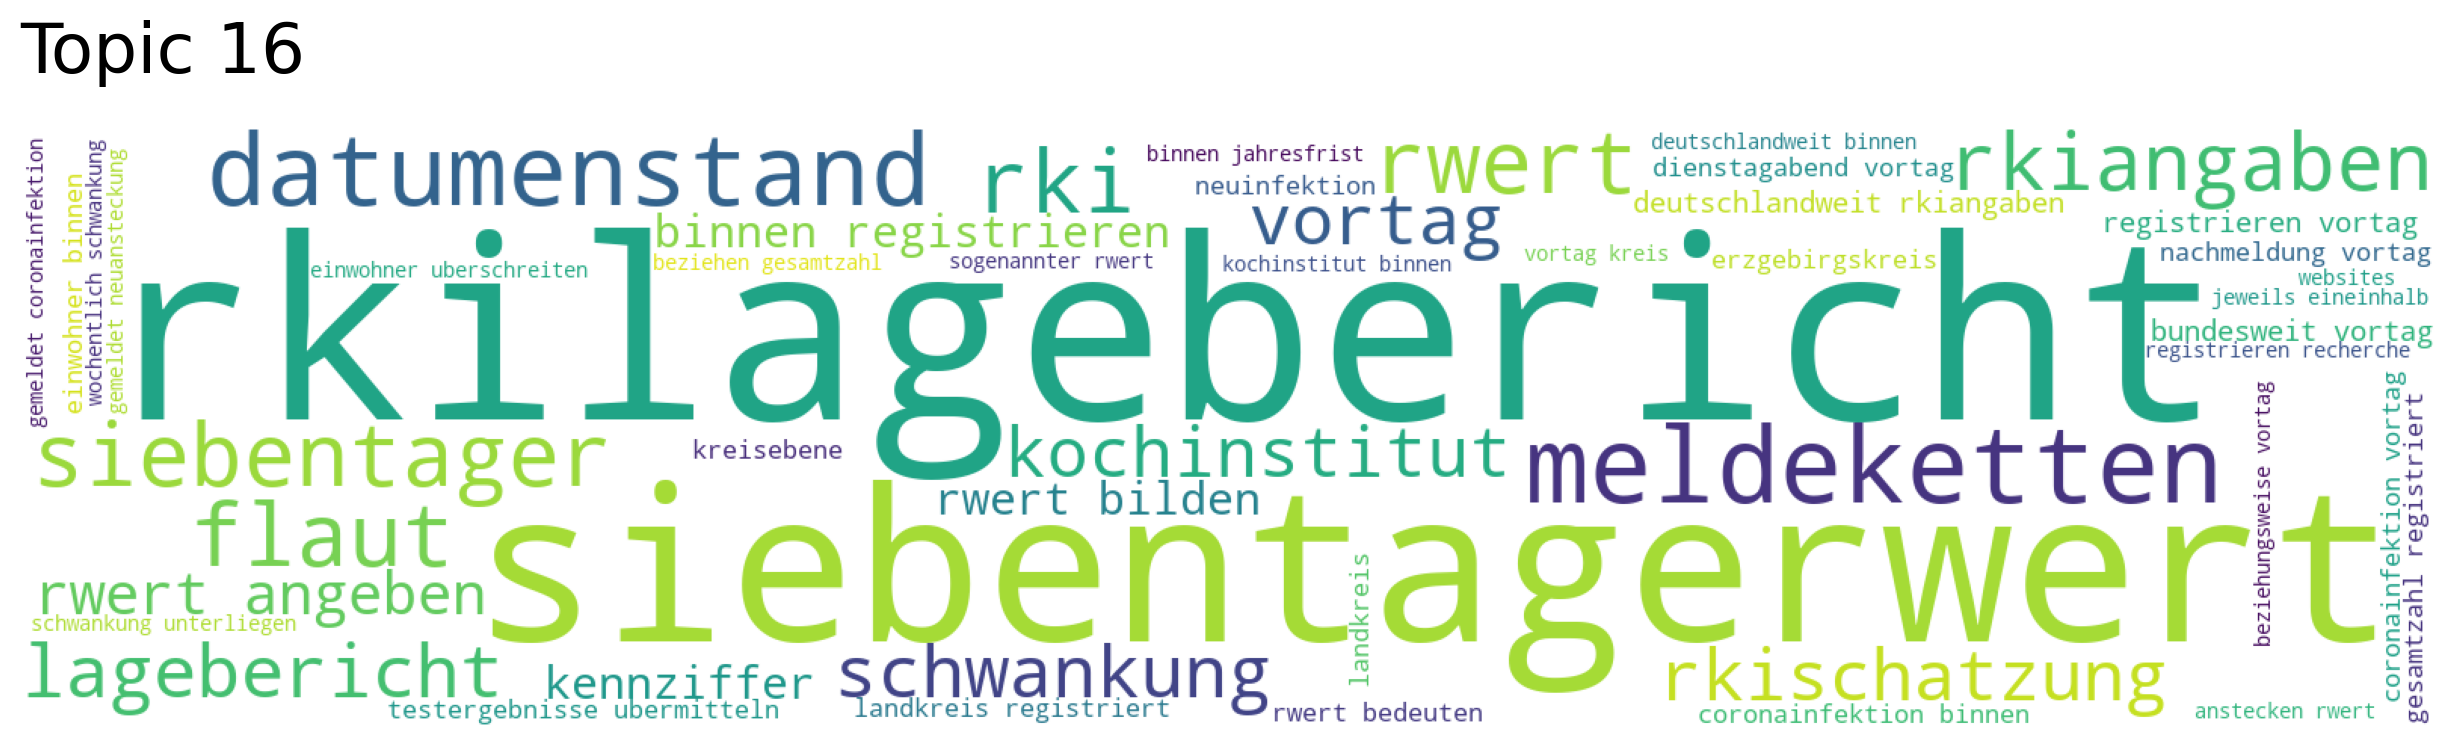

In [22]:
model.generate_topic_wordcloud(16, background_color='white', reduced=True)

In [23]:
label_dict = {0: 'U.S. News', 1: 'Financial / economic crisis', 2: 'Cultural sector', 3: 'Federal protective measures', 4: 'Soccer', 5: 'Social discourse', 6: 'Vaccine development', 7: 'Social interactions', 8: 'Police & Demonstrations', 9: 'Travel restrictions', 10: 'Hospital care', 11: 'Retail', 12: 'Infections & Contact tracker', 13: 'Federal elections', 14: 'School & Pupils', 15: 'Vaccinations', 16: 'Infection reportings'}

In [24]:
reduced_labels = model.doc_top_reduced

In [25]:
reduced_labels = np.vectorize(label_dict.get)(reduced_labels)

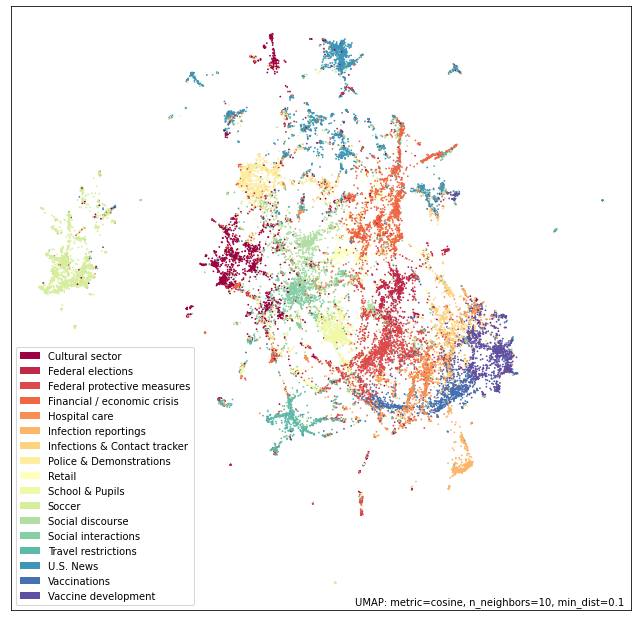

In [34]:
import umap.plot
umap_args_model = {"n_neighbors": 10, "n_components": 2, "metric": "cosine", 'min_dist':0.10, 'spread':1}
umap_model = umap.UMAP(**umap_args_model).fit(model.document_vectors)
umap_fig2 = umap.plot.points(umap_model, labels = reduced_labels)
umap_fig2.figure.savefig('../figures/umap.png')

## Option 2: BERTopic

In [ ]:
topic_model = BERTopic(language="German", verbose=True, n_gram_range=(1,2))

In [ ]:
# preprocessed text
with mgzip.open('../data/combined_news_pre.mgzip', 'rb') as handle:
    combined_news_pre = pickle.load(handle)

In [ ]:
docs = combined_news_pre.combined_text_joined.to_list()

In [ ]:
topics, probs = topic_model.fit_transform(docs)

In [ ]:
topic_model.save("../models/bert_reduced.bt")

In [ ]:
topic_model = topic_model.load("../models/bert_reduced.bt")

In [26]:
topics = topic_model.get_topic_info()

In [59]:
new_topics, new_probs = topic_model.reduce_topics(docs, topics, probs, nr_topics=20)

2022-06-20 18:01:00,442 - BERTopic - Reduced number of topics from 191 to 21


# Construct prediction dataset

In [64]:
combined_news_pre.reset_index(inplace=True)

ValueError: cannot insert level_0, already exists

In [42]:
topic_nums = pd.DataFrame(topic_nums)
topic_nums.columns = ['top2vec_0', 'top2vec_1']

In [43]:
topic_nums = pd.merge(topic_nums, combined_news_pre[['title', 'newspaper']], left_index=True, right_index=True)

In [50]:
topic_counts = topic_nums.groupby(['newspaper', 'top2vec_0'], as_index = False).agg(count=('title', np.count_nonzero))

In [85]:
labels=['U.S. News', 'Financial / economic crisis', 'Cultural sector', 'Federal protective measures', 'Soccer', 'Social discourse', 'Vaccine development', 'Social interactions', 'Police & Demonstrations', 'Travel restrictions', 'Hospital care', 'Retail', 'Infections & Contact tracker', 'Federal elections', 'School & Pupils', 'Vaccinations', 'Infection reportings']
tagesspiegel_counts = list(topic_counts[topic_counts['newspaper'] == 'tagespiegel']['count'])
tagesspiegel_counts = [x / sum(tagesspiegel_counts) for x in tagesspiegel_counts]
welt_counts = list(topic_counts[topic_counts['newspaper'] == 'welt']['count'])
welt_counts = [x / sum(welt_counts) for x in welt_counts]
zeit_counts = list(topic_counts[topic_counts['newspaper'] == 'zeit']['count'])
zeit_counts = [x / sum(zeit_counts) for x in zeit_counts]

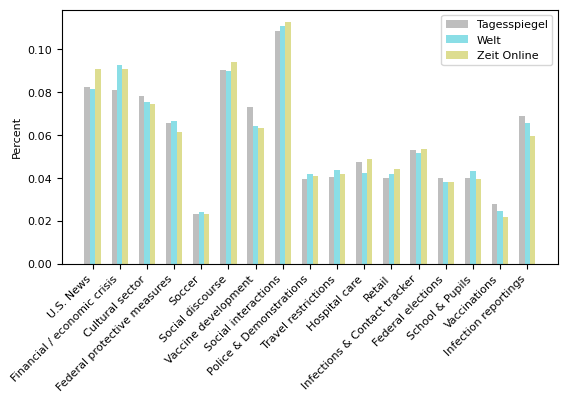

In [112]:
import matplotlib.pyplot as plt
x = np.arange(len(labels))
width = 0.2
fig, ax = plt.subplots()
rects1 = ax.bar(x - 0.2, tagesspiegel_counts, width, label='Tagesspiegel', alpha=0.5, color='tab:gray')
rects2 = ax.bar(x , welt_counts, width, label='Welt', alpha=0.5, color='tab:cyan')
rects3 = ax.bar(x + 0.2, zeit_counts, width, label='Zeit Online', alpha=0.5, color='tab:olive')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Percent')
ax.set_xticks(x, labels)
ax.legend()
fig.autofmt_xdate(rotation=45)
plt.gcf().subplots_adjust(bottom=0.35)
plt.rcParams.update({'font.size': 4})
plt.savefig('../figures/frequency_topics.png')

In [67]:
# join with sentiment predictions
predict = pd.merge(combined_predict, combined_news_pre, on='title', how='inner')

In [68]:
# join with top2vec topics
predict = pd.merge(predict, topic_nums, on='title', how='inner')

In [69]:
# drop duplicate articles, seem to be a few generated while webscraping
predict = predict.drop_duplicates(subset=['date', 'title', 'count_adj', 'count_nn'])

# Spacy document2vector, already calculated and can be loaded through file at the end

In [16]:
#nlp = spacy.load('de_core_news_lg')

#def get_doc_vec(input):
#    doc = nlp(input)
#    vector = list(doc.vector)
#    del doc
#    return vector

#predict['spacy'] = predict['combined_text_joined'].progress_apply(get_doc_vec)

#spacy = pd.DataFrame()
#spacy[["vec" + str(int(x)) for x in np.linspace(start=0, stop=299, num=300)]] = X.spacy.apply(pd.Series)

#from sklearn.manifold import TSNE
#tsne = TSNE()
#tsne_vectors = tsne.fit_transform(spacy)
#tsne_vectors = pd.DataFrame(index=spacy.index, data=tsne_vectors)
#test = {
#    'x_coord' : tsne_vectors[0].values,
#    'y_coord' : tsne_vectors[1].values
#}
#tsne_vectors = pd.DataFrame(test, index=pd.Index(spacy.index))

#from bokeh.plotting import figure, show, output_notebook
#from bokeh.models import HoverTool, ColumnDataSource, value

#output_notebook()

#plot_data = ColumnDataSource(data=tsne_vectors)

# create the plot and configure the
# title, dimensions, and tools
#tsne_plot = figure(title=u't-SNE Word Embeddings',
#                   plot_width = 800,
#                   plot_height = 800,
#                   tools= (u'pan, wheel_zoom, box_zoom,'
#                           u'box_select, reset'),
#                   active_scroll=u'wheel_zoom')

# add a hover tool to display words on roll-over
#tsne_plot.add_tools( HoverTool(tooltips = u'@index') )


# draw the words as circles on the plot
#tsne_plot.circle(x=u'x_coord',
#                 y=u'y_coord',
#                 source=plot_data,
#                 line_alpha=0.2,
#                 fill_alpha=1,
#                 size=10,
#                 hover_line_color=u'black')

# configure visual elements of the plot
#tsne_plot.xaxis.visible = False
#tsne_plot.yaxis.visible = False
#tsne_plot.grid.grid_line_color = None
#tsne_plot.outline_line_color = None

# engage!
#show(tsne_plot);

#spacy = pd.DataFrame()
#spacy[["vec" + str(int(x)) for x in np.linspace(start=0, stop=299, num=300)]] = X.spacy.apply(pd.Series)

In [70]:
# load command
with mgzip.open('../data/spacy.mgzip', 'rb') as handle:
    spacy = pickle.load(handle)

In [71]:
X = predict[['count', 'newspaper', 'avg_length', 'avg_length_sent', 'count_adj', 'percent_adj', 'count_nn', 'percent_nn', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg', 'top2vec_0', 'top2vec_1']]

In [72]:
X = pd.merge(X, spacy, left_index=True, right_index=True)

In [73]:
X[['tagespiegel', 'welt', 'zeit']] = pd.get_dummies(X['newspaper'])

In [74]:
X.drop('newspaper', axis=1, inplace=True)

In [75]:
y = predict['calc']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Predict
## Random Forests

In [80]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 5 , cv = 3, verbose = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train,y_train)

rf_random.best_params_

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 3/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.097 total time=  39.8s
[CV 1/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.079 total time= 5.0min


Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.


[CV 1/3] END bootstrap=True, max_depth=50, max_features=sqrt, min_samples_leaf=2, min_samples_split=10, n_estimators=200;, score=0.076 total time=  42.3s
[CV 2/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.077 total time= 5.2min
[CV 2/3] END bootstrap=False, max_depth=90, max_features=sqrt, min_samples_leaf=4, min_samples_split=10, n_estimators=600;, score=0.077 total time= 3.0min
[CV 3/3] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=1400;, score=0.097 total time= 5.2min


KeyboardInterrupt: 

In [81]:
regr = RandomForestRegressor(verbose=1, n_jobs=-1)
#regr = RandomForestRegressor(verbose = 1, n_jobs = -1, n_estimators = 670, min_samples_split = 5, min_samples_leaf = 1, max_features = 'auto', max_depth = 12, criterion = 'gini')
regr.fit(X_train, y_train)
regr.score(X_test, y_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   30.2s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.2min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.1s finished


0.7797828576689275

## XGBoost

In [83]:
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score

scores = cross_val_score(XGBRegressor(), X, y)
scores.mean()

0.6901408356737181

# Export for R / Tableau

In [78]:
predict_small = predict[['calc', 'value', 'count', 'date', 'newspaper', 'top2vec_0', 'top2vec_1', 'drosten', 'kekulé', 'lauterbach', 'streeck', 'wodarg', 'avg_length', 'count_nn', 'count_adj', 'percent_adj', 'percent_nn']]

In [79]:
pyreadr.write_rdata("../data/predict_small.RData", predict_small, df_name="predict")

In [80]:
predict_small.to_csv("../data/predict_small.csv")

In [82]:
with mgzip.open('../data/predict.mgzip', 'wb') as handle:
    pickle.dump(predict, handle)